In [1]:
# ============================================================================
# CELDA 1: CONFIGURACIÓN E IMPORTS
# ============================================================================
%run ./00_template.py
import sys
import subprocess
import fiona
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar

# Configuración de ejecución
AUTO_EJECUTAR_ETL = True       # Si True, intenta correr los scripts si faltan datos
FORZAR_RECALCULO = False       # Si True, borra y crea todo de nuevo (lento)

print("🚀 Notebook 01 Iniciado: Adquisición y Pipeline ETL")
print_status() # Función nueva que agregamos a tu template

=== 🌍 Template PEP1 Configurado Exitosamente ===
📂 Base Dir       : /home/jovyan
💾 GeoDatabase    : ✅ Encontrada
📊 Censo CSV      : ✅ Encontrado
🚀 Notebook 01 Iniciado: Adquisición y Pipeline ETL
=== 🌍 Template PEP1 Configurado Exitosamente ===
📂 Base Dir       : /home/jovyan
💾 GeoDatabase    : ✅ Encontrada
📊 Censo CSV      : ✅ Encontrado


In [2]:
# ============================================================================
# CELDA 2: DEFINICIÓN DE PIPELINE
# ============================================================================
# Definimos los scripts externos que hacen el trabajo sucio
SCRIPTS_ETL = {
    "limpieza_censo": CARGA_DIR / "RM_clean_data.py",
    "construccion_gpkg": CARGA_DIR / "ETL.py"
}

def ejecutar_script_externo(script_path: Path, work_dir: Path) -> bool:
    """Ejecuta un script Python como subproceso y reporta éxito/fracaso."""
    if not script_path.exists():
        print(f"❌ Error crítico: Script no encontrado -> {script_path.name}")
        return False

    print(f"⚙️  Ejecutando: {script_path.name}...")
    try:
        result = subprocess.run(
            [sys.executable, str(script_path)],
            cwd=str(work_dir),
            capture_output=True,
            text=True,
            check=True # Esto lanza error si el script falla
        )
        # Opcional: imprimir stdout solo si es necesario o hay error
        # print(result.stdout) 
        print(f"✅ Éxito: {script_path.name} finalizó correctamente.")
        return True
    except subprocess.CalledProcessError as e:
        print(f"🔥 Fallo en {script_path.name}:\n{e.stderr}")
        return False

In [3]:
# ============================================================================
# CELDA 3: ORQUESTACIÓN DEL ETL
# ============================================================================

if AUTO_EJECUTAR_ETL:
    # PASO 1: Generar datos censales si no existen
    if FORZAR_RECALCULO or not RUTA_CENSO_CSV.exists():
        print("🔄 Generando CSV Censal...")
        ejecutar_script_externo(SCRIPTS_ETL["limpieza_censo"], CARGA_DIR)
    else:
        print("✅ Datos censales ya disponibles (saltando re-cálculo).")

    # PASO 2: Construir la Geodatabase
    if FORZAR_RECALCULO or not RUTA_GPKG.exists():
        print("🔄 Construyendo GeoPackage (esto puede tardar)...")
        ejecutar_script_externo(SCRIPTS_ETL["construccion_gpkg"], CARGA_DIR)
    else:
        print("✅ GeoDatabase ya disponible (saltando re-cálculo).")
else:
    print("⚠️  AUTO_EJECUTAR_ETL desactivado. Verificando archivos existentes...")

# Verificación final bloqueante
if not RUTA_GPKG.exists():
    raise FileNotFoundError("❌ CRÍTICO: No existe la Geodatabase. Ejecuta el ETL.")

✅ Datos censales ya disponibles (saltando re-cálculo).
✅ GeoDatabase ya disponible (saltando re-cálculo).


In [4]:
# ============================================================================
# CELDA 4: INVENTARIO DE DATOS (CATÁLOGO)
# ============================================================================
# Listar capas sin cargar toda la geometría (más rápido)
capas_disponibles = fiona.listlayers(RUTA_GPKG)
print(f"📂 Contenido de {RUTA_GPKG.name}: {len(capas_disponibles)} capas")

# Crear catálogo detallado
info_capas = []
for layer_name in capas_disponibles:
    # Leemos solo 1 fila para sacar metadatos rápido
    gdf_meta = gpd.read_file(RUTA_GPKG, layer=layer_name, rows=1)
    
    # Contamos el total usando fiona (mucho más rápido que len(gpd))
    with fiona.open(RUTA_GPKG, layer=layer_name) as src:
        total_feats = len(src)
        
    info_capas.append({
        "Capa": layer_name,
        "Registros": total_feats,
        "Tipo": gdf_meta.geom_type.iloc[0] if not gdf_meta.empty else "N/A",
        "CRS": str(gdf_meta.crs)
    })

df_catalogo = pd.DataFrame(info_capas).sort_values("Capa")

# Guardar reporte
reporte_path = PROCESSED_DATA / "catalogo_geodatabase.csv"
df_catalogo.to_csv(reporte_path, index=False)

display(df_catalogo) # Muestra la tabla bonita en Jupyter
print(f"📄 Catálogo exportado a: {reporte_path}")

📂 Contenido de geodatabase_proyecto.gpkg: 20 capas


,Capa,Registros,Tipo,CRS
10,areas_verdes,7508,MultiPolygon,EPSG:32719
4,companias_bomberos,142,Point,EPSG:32719
0,comunas_rm_censo,52,Polygon,EPSG:32719
3,cuarteles_carabineros,128,Point,EPSG:32719
2,establecimientos_educacion,2918,Point,EPSG:32719
11,establecimientos_educacion_superior,526,Point,EPSG:32719
1,establecimientos_salud,1027,Point,EPSG:32719
9,ferias_libres,370,MultiLineString,EPSG:32719
7,infraestructura_deportiva,4896,Point,EPSG:32719
8,municipios,52,Point,EPSG:32719


📄 Catálogo exportado a: /home/jovyan/data/processed/catalogo_geodatabase.csv


✅ Cargado Capa 'comunas_rm_censo': 52 registros | CRS: EPSG:32719
✅ Cargado Capa 'establecimientos_salud': 1027 registros | CRS: EPSG:32719
✅ Cargado Capa 'establecimientos_educacion': 2918 registros | CRS: EPSG:32719
✅ Cargado Capa 'osm_supermercados': 546 registros | CRS: EPSG:32719
🖼️  Imagen guardada: 01_validacion_qa_mapa.png


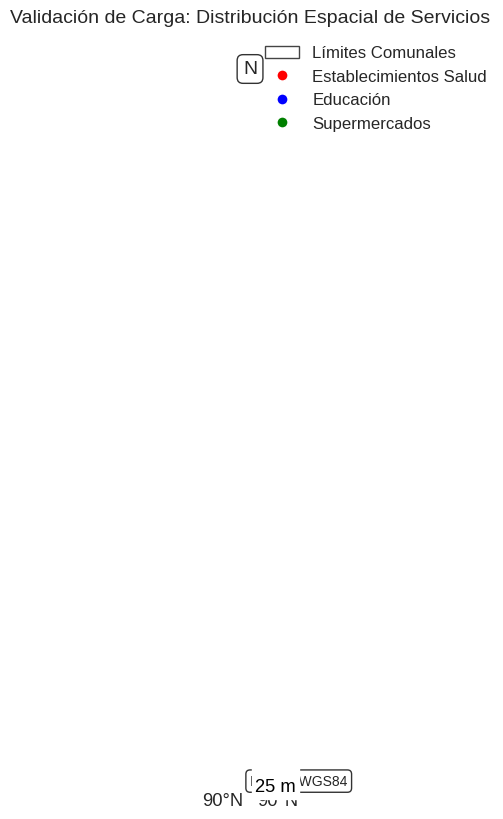

In [5]:
# ============================================================================
# CELDA 5: CONTROL DE CALIDAD VISUAL (QA MAP)
# ============================================================================

# Definición de qué queremos validar visualmente
LAYERS_TO_PLOT = {
    "Establecimientos Salud": {"layer": "establecimientos_salud", "color": "red", "size": 15},
    "Educación": {"layer": "establecimientos_educacion", "color": "blue", "size": 5},
    "Supermercados": {"layer": "osm_supermercados", "color": "green", "size": 10}
}

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# 1. Base: Comunas
comunas = load_geodata(RUTA_GPKG, layer="comunas_rm_censo")
if comunas is not None:
    comunas.boundary.plot(ax=ax, color="#444444", linewidth=0.5, zorder=1, transform=ccrs.PlateCarree())

# 2. Capas de servicios (Loop dinámico)
legend_elements = [mpatches.Patch(facecolor="none", edgecolor="#444444", label="Límites Comunales")]

for label, props in LAYERS_TO_PLOT.items():
    gdf = load_geodata(RUTA_GPKG, layer=props["layer"])
    if gdf is not None:
        gdf.plot(ax=ax, color=props["color"], markersize=props["size"], alpha=0.6, zorder=2, transform=ccrs.PlateCarree())
        # Agregar a la leyenda
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label=label,
                              markerfacecolor=props["color"], markersize=8))

# 3. Estética final
ax.set_title("Validación de Carga: Distribución Espacial de Servicios", fontsize=14)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_axis_off()

# Agregar elementos del mapa
# Cuadrícula de coordenadas
ax.gridlines(draw_labels=True, alpha=0.5)
# Escala gráfica
scalebar = ScaleBar(1, location='lower left', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)
# Sistema de referencia
ax.text(0.02, 0.02, 'Datum: WGS84', transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
# Flecha del norte
ax.annotate('N', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=14, ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.arrow(0.05, 0.9, 0, 0.05, head_width=0.01, head_length=0.01, fc='black', ec='black', transform=ax.transAxes)

save_figure(fig, "01_validacion_qa_mapa")
plt.show()